In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rpy2.robjects import r, pandas2ri

# auto convertation Pandas DataFrame in R DataFrame
pandas2ri.activate()

# kallisto data
counts_file_Rep1_treat = "quant/Andromeda_Rep1_139.1/abundance.tsv"
counts_file_Rep2_treat = "quant/Andromeda_Rep2_139.1/abundance.tsv"
counts_file_Rep3_treat = "quant/Andromeda_Rep3_139.1/abundance.tsv"

counts_file_Rep1_control = "quant/Andromeda_Rep1_Control/abundance.tsv"
counts_file_Rep2_control = "quant/Andromeda_Rep2_Control/abundance.tsv"
counts_file_Rep3_control = "quant/Andromeda_Rep3_Control/abundance.tsv"

# kallisto data in Pandas DataFrame
counts_Rep1_control = pd.read_csv(counts_file_Rep1_control, sep='\t')
counts_Rep2_control = pd.read_csv(counts_file_Rep2_control, sep='\t')
counts_Rep3_control = pd.read_csv(counts_file_Rep3_control, sep='\t')

counts_Rep1_treatment = pd.read_csv(counts_file_Rep1_treat, sep='\t')
counts_Rep2_treatment = pd.read_csv(counts_file_Rep2_treat, sep='\t')
counts_Rep3_treatment = pd.read_csv(counts_file_Rep3_treat, sep='\t')

# extract TRINITY id and counts
counts_Rep1_control = counts_Rep1_control[['target_id', 'est_counts']]
counts_Rep2_control = counts_Rep2_control[['target_id', 'est_counts']]
counts_Rep3_control = counts_Rep3_control[['target_id', 'est_counts']]

counts_Rep1_treatment = counts_Rep1_treatment[['target_id', 'est_counts']]
counts_Rep2_treatment = counts_Rep2_treatment[['target_id', 'est_counts']]
counts_Rep3_treatment = counts_Rep3_treatment[['target_id', 'est_counts']]

# convert TRINITY id to an index
counts_Rep1_control.set_index('target_id', inplace=True)
counts_Rep2_control.set_index('target_id', inplace=True)
counts_Rep3_control.set_index('target_id', inplace=True)

counts_Rep1_treatment.set_index('target_id', inplace=True)
counts_Rep2_treatment.set_index('target_id', inplace=True)
counts_Rep3_treatment.set_index('target_id', inplace=True)

# combined to DataFrame
counts_combined = pd.concat([counts_Rep1_control, counts_Rep2_control, counts_Rep3_control,
                             counts_Rep1_treatment, counts_Rep2_treatment, counts_Rep3_treatment], axis=1)
counts_combined.columns = ['Andromeda_Rep1_Control', 'Andromeda_Rep2_Control', 'Andromeda_Rep3_Control',
                           'Andromeda_Rep1_139.1', 'Andromeda_Rep2_139.1', 'Andromeda_Rep3_139.1']
counts_combined = counts_combined.astype(int)

# create DESeq2 object
r('library(DESeq2)')

# convert DataFrame in R DataFrame
counts_r = pandas2ri.py2rpy(counts_combined)
r.assign('counts_r', counts_r)

col_data = pd.DataFrame({
    'condition': ['control', 'control', 'control', 'treated', 'treated', 'treated']
}, index=['Andromeda_Rep1_Control', 'Andromeda_Rep2_Control', 'Andromeda_Rep3_Control',
          'Andromeda_Rep1_139.1', 'Andromeda_Rep2_139.1', 'Andromeda_Rep3_139.1']) 

col_data_r = pandas2ri.py2rpy(col_data)
r.assign('col_data_r', col_data_r)

# create DESeqDataSet
dds = r('DESeqDataSetFromMatrix(countData=counts_r, colData=col_data_r, design=~condition)')
r.assign('dds', dds)
# make DESeq analysis
r('dds <- DESeq(dds)')

# get result
r('res_df <- as.data.frame(results(dds))')

# convert R DataFrame in Pandas DataFrame
results_df = r('res_df')
results_df = pandas2ri.rpy2py(results_df)

# save result
#results_df.to_csv('Andromeda_139.1_differential_expression_results.csv', index=False)


In [3]:
# cor_matrix
r("round(cor(counts_r) ** 2, 2)")

array([[1.  , 0.3 , 0.77, 0.87, 0.86, 0.25],
       [0.3 , 1.  , 0.29, 0.29, 0.25, 0.8 ],
       [0.77, 0.29, 1.  , 0.89, 0.88, 0.2 ],
       [0.87, 0.29, 0.89, 1.  , 0.93, 0.21],
       [0.86, 0.25, 0.88, 0.93, 1.  , 0.19],
       [0.25, 0.8 , 0.2 , 0.21, 0.19, 1.  ]])

/tmp/ipykernel_206687/3372899174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_proc['padj'] = pd.to_numeric(filtered_df_proc['padj'], errors='coerce')
/tmp/ipykernel_206687/3372899174.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_proc['log2FoldChange'] = pd.to_numeric(filtered_df_proc['log2FoldChange'], errors='coerce')


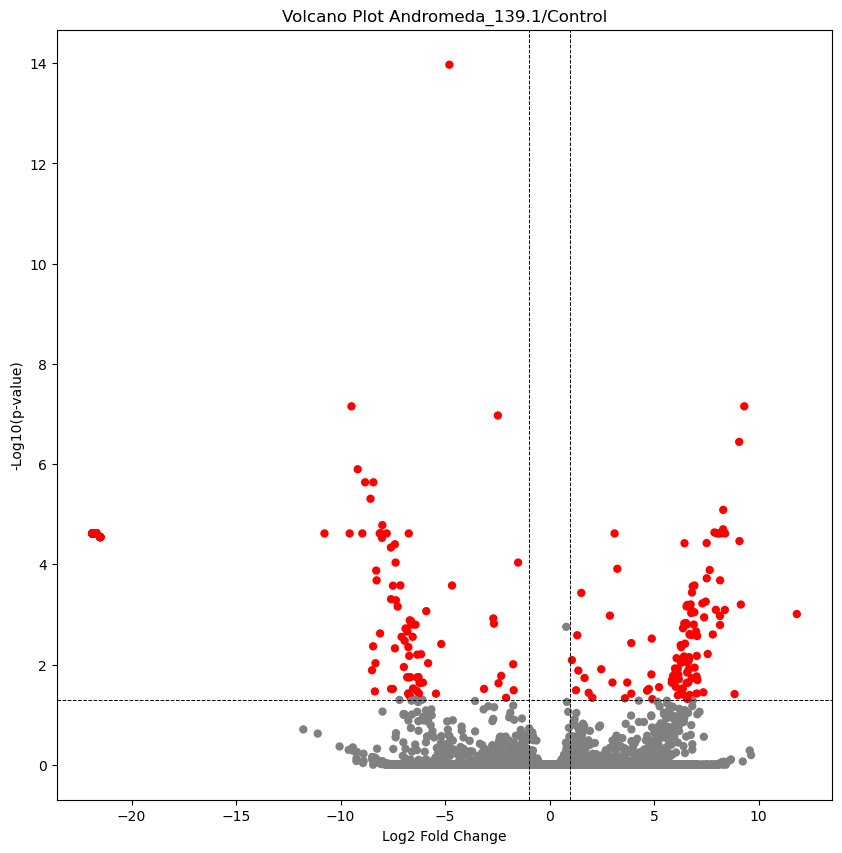

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

filtered_df_proc = results_df.dropna(subset=['padj', 'log2FoldChange'])

filtered_df_proc['padj'] = pd.to_numeric(filtered_df_proc['padj'], errors='coerce')
filtered_df_proc['log2FoldChange'] = pd.to_numeric(filtered_df_proc['log2FoldChange'], errors='coerce')

filtered_df_proc = filtered_df_proc.dropna(subset=['padj'])
filtered_df_proc = filtered_df_proc.dropna(subset=['log2FoldChange'])

# add -log10(pvalue) for volcano plot
filtered_df_proc['-log10(pvalue)'] = -np.log10(filtered_df_proc['padj'])

significance_threshold = 0.05
fold_change_threshold = 1

# definition significant data
filtered_df_proc['significant'] = (filtered_df_proc['padj'] < significance_threshold) & \
                                  (np.abs(filtered_df_proc['log2FoldChange']) > fold_change_threshold)

plt.figure(figsize=(10, 10))

sns.scatterplot(x='log2FoldChange', y='-log10(pvalue)', hue='significant', 
                data=filtered_df_proc, edgecolor='none', palette={True: 'red', False: 'grey'}, legend=False)

plt.axhline(y=-np.log10(significance_threshold), color='black', linestyle='--', linewidth=0.7)
plt.axvline(x=-fold_change_threshold, color='black', linestyle='--', linewidth=0.7)
plt.axvline(x=fold_change_threshold, color='black', linestyle='--', linewidth=0.7)

plt.title('Volcano Plot Andromeda_139.1/Control')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')

plt.show()


In [5]:
# normalization 
vst_data = r('vst(dds, blind=FALSE)') #for big data
# or rlog for small data:
# rlog_data = r('rlog(dds, blind=FALSE)')
r.assign('vst_data', vst_data)
norm_counts = r('assay(vst_data)')

# convert to Pandas DataFrame
norm_counts_df = pd.DataFrame(norm_counts, columns=col_data.index, index=counts_combined.index)


/tmp/ipykernel_141871/180064495.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(sample, (pca_df['PC1'][i], pca_df['PC2'][i]),


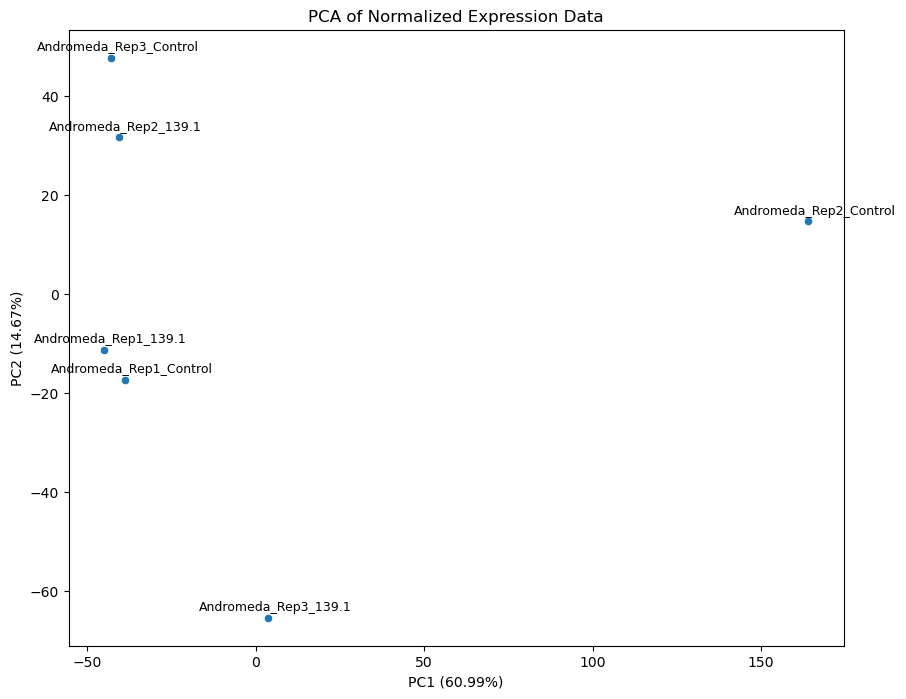

In [143]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

norm_counts_transposed = norm_counts_df.T

pca = PCA(n_components=2)
pca_result = pca.fit_transform(norm_counts_transposed)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=norm_counts_transposed.index)

# Визуализируем результаты PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
# Подписи для каждой точки (индексы образцов)
for i, sample in enumerate(pca_df.index):
    plt.annotate(sample, (pca_df['PC1'][i], pca_df['PC2'][i]), 
                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

# Настройки графика
plt.title('PCA of Normalized Expression Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.show()


In [ ]:
import pandas as pd

# read blast annot
blast_df = pd.read_csv('blast/cd_hit_classic_annot', sep='\t', header=None)
blast_df.columns = ['target_id', 'protein_id', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 
                    'q_start', 'q_end', 's_start', 's_end', 'e_value', 'bit_score']

results_df_proc = results_df.reset_index()
results_df_proc = results_df_proc.rename(columns={'index': 'target_id'})

# merge table by target_id and add pritein_id from blast annot table
merged_df = pd.merge(results_df_proc, blast_df[['target_id', 'protein_id']], on='target_id', how='left')

# delete the lines that contain NaN at 'protein_id', 'log2FoldChange' and 'padj'
filtered_df = merged_df.dropna(subset=['protein_id', 'log2FoldChange', 'padj'])

# filter by protein_id and log2FoldChange
def filter_log2fc(group):
    pos_log2fc = group['log2FoldChange'] > 0
    neg_log2fc = group['log2FoldChange'] < 0
    
    # If all log2FoldChange are down-regulated, save the line with the min log2FoldChange on the protein_id
    if all(neg_log2fc):
        return group.loc[group['log2FoldChange'].idxmin()].to_frame().T
    
    # If all log2FoldChange are up-regulated, save the line with the max log2FoldChange on the protein_id
    elif all(pos_log2fc):
        return group.loc[group['log2FoldChange'].idxmax()].to_frame().T
    
    # If all log2FoldChange are up-regulated and down-regulated, delete this protein_id
    else:
        return pd.DataFrame()

# application function at groups with same protein_id
unique_df = filtered_df.groupby('protein_id', group_keys=False).apply(filter_log2fc).reset_index(drop=True)

unique_df = unique_df.dropna(how='all')

unique_df = unique_df.sort_values(by=['log2FoldChange', 'target_id'], ascending=[False, False])

#unique_df.to_csv('quant/Andromeda_139.1_deseq.tsv', sep='\t', index=False)


/tmp/ipykernel_141871/1671274181.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(sample, (pca_df['PC1'][i], pca_df['PC2'][i]),


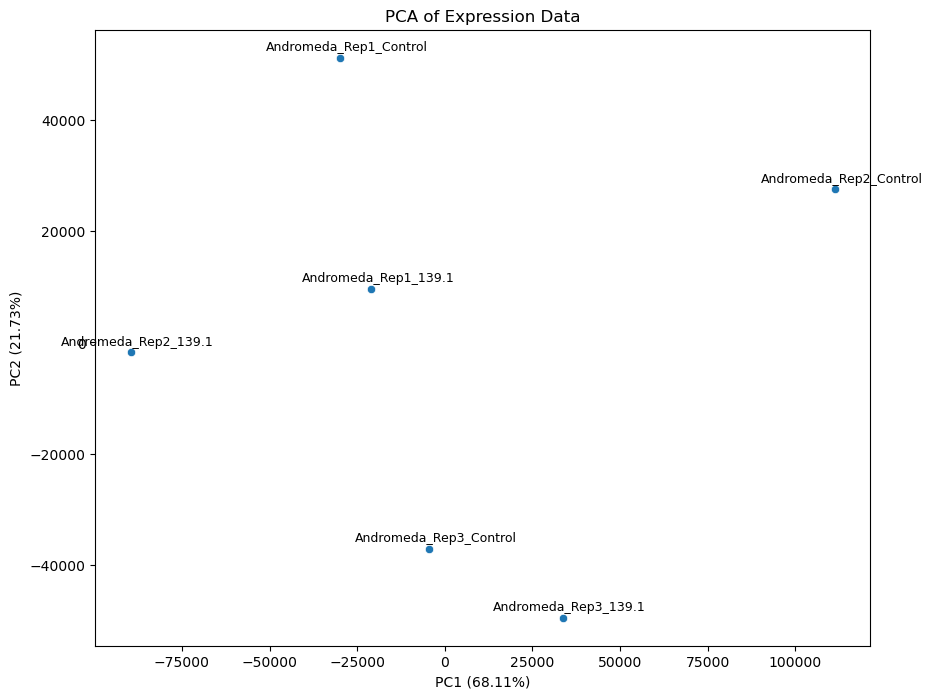

In [172]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Транспонируем данные так, чтобы образцы были строками, а гены столбцами
norm_counts_transposed = filtered_counts_combined.T

# Выполняем PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(norm_counts_transposed)

# Преобразуем результат в DataFrame для визуализации
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=norm_counts_transposed.index)

# Визуализируем результаты PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
# Подписи для каждой точки (индексы образцов)
for i, sample in enumerate(pca_df.index):
    plt.annotate(sample, (pca_df['PC1'][i], pca_df['PC2'][i]), 
                 textcoords="offset points", xytext=(5,5), ha='center', fontsize=9)

# Настройки графика
plt.title('PCA of Expression Data')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.show()


In [185]:
import pandas as pd
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr

# Включаем поддержку Pandas в rpy2
pandas2ri.activate()

# Импортируем необходимые библиотеки из R
pheatmap = importr('pheatmap')
RColorBrewer = importr('RColorBrewer')

# Создаем матрицу расстояний между образцами
r.assign('norm_counts_df', pandas2ri.py2rpy(norm_counts_df))
r('sampleDists <- dist(t(norm_counts_df))')

# Создаем матрицу расстояний
r('sampleDistMatrix <- as.matrix(sampleDists)')

# Настраиваем имена строк
r('rownames(sampleDistMatrix) <- paste(vsd$condition, vsd$type, sep="-")')
r('colnames(sampleDistMatrix) <- NULL')

# Создаем палитру цветов
r('colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)')

# Генерируем тепловую карту
r('pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors)')


PackageNotInstalledError: The R package "pheatmap" is not installed.

In [178]:
!conda install pheatmap -y

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - pheatmap

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge/linux-64
  - https://conda.anaconda.org/bioconda/linux-64

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


